## Basic Import

In [1]:
import argparse
import itertools
import random
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torchcp.classification.loss import ConfTr
from torchcp.classification.predictors import SplitPredictor, ClusterPredictor, ClassWisePredictor
from torchcp.classification.scores import THR, APS, SAPS, RAPS
from torchvision.models import resnet18
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision.datasets import ImageFolder
import torchvision
import torchvision.models as models
import pandas as pd

### Device

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Hyperparameters

In [3]:
# Set experiment parameters
alphas = [0.1, 0.05, 0.025] #0.01
num_trials = 5
NUM_EPOCHS = 10
predictors = ["SplitPredictor", "ClusterPredictor", "ClassWisePredictor"]
scores = ["THR", "APS","RAPS", "SAPS"]
weight_selections = [0.2,0.5,0.7,1,2]
alphas = [0.025,0.05,0.1]
weight = 0.2

## Data Loder

#### MNIST

In [4]:
# Load MNIST dataset
transform_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset_mnist = MNIST(root='./dataset', train=True, download=True, transform=transform_mnist)

# Split dataset
train_size_mnist = int(0.8 * len(dataset_mnist))
cal_size_mnist = int(0.1 * len(dataset_mnist))
test_size_mnist = len(dataset_mnist) - train_size_mnist - cal_size_mnist
train_dataset_mnist, cal_dataset_mnist, test_dataset_mnist = random_split(dataset_mnist, [train_size_mnist, cal_size_mnist, test_size_mnist])

# Set loaders
train_loader_mnist = DataLoader(train_dataset_mnist, batch_size=512, shuffle=True, pin_memory=True)
cal_loader_mnist = DataLoader(cal_dataset_mnist, batch_size=1600, shuffle=False, pin_memory=True)
test_loader_mnist = DataLoader(test_dataset_mnist, batch_size=1600, shuffle=False, pin_memory=True)

## Model

#### LeNet5

In [5]:
# Define LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        return x

#### Simple CNN

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # Define the fully connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Forward pass through the network
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 32 * 7 * 7)  # Flatten the output for the fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### Modified ResNet-18

In [7]:
class ModifiedResNet18(nn.Module):
    def __init__(self):
        super(ModifiedResNet18, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        # 使用预训练的ResNet-18模型，然后修改第一个卷积层的输入通道数
        # 修改输入通道数为1
        self.resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    def forward(self, x):
        return self.resnet18(x)

## Training

In [8]:
def train(model):
    for epoch in range(NUM_EPOCHS):
        model.train()
        for images, labels in train_loader_mnist:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    corrects = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader_mnist:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            corrects += (predicted == labels).sum().item()

    acc =corrects / total
    print(f"Accuracy on MNIST: {acc * 100:.4f}%")

## Conformal Prediction

In [23]:
def c_prediction(model,score_function, predictor_type,test_data_loader,cal_data_loader,alpha):
    model.eval()
    if score_function == "THR":
        score_function = THR()
    elif score_function == "APS":
        score_function = APS()
    elif score_function == "RAPS":
        score_function = RAPS(1, 0)
    elif score_function == "SAPS":
        score_function = SAPS(weight)
    
    if predictor_type == "SplitPredictor":
        predictor = SplitPredictor(score_function, model)
    elif predictor_type == "ClusterPredictor":
        predictor = ClusterPredictor(score_function, model)
    elif predictor_type == "ClassWisePredictor":
        predictor = ClassWisePredictor(score_function, model)
    else:
        raise NotImplementedError
    predictor.calibrate(cal_data_loader, alpha)                
    result = predictor.evaluate(test_data_loader)
    return result['Coverage_rate'],result['Average_size']

## Results

### SimpleCNN on MNIST

In [10]:
criterion = nn.CrossEntropyLoss()
CNN_model = SimpleCNN().to(device)
optimizer = optim.Adam(CNN_model.parameters(), lr=0.001)
train(CNN_model)

Accuracy on MNIST: 98.7667%


#### Compare with different score functions and predictors(weight of SAPS=0.2,alpha=0.05)

In [37]:
weight = 0.2
CNN_results = pd.DataFrame([
    {
        "Predictor": predictor,
        "Score Function": score_function,
        "Coverage Rate": c_prediction(CNN_model, score_function, predictor, test_loader_mnist, cal_loader_mnist, alpha=0.05)[0],
        "Average Size": c_prediction(CNN_model, score_function, predictor, test_loader_mnist, cal_loader_mnist, alpha=0.05)[1],
    }
    for predictor in predictors
    for score_function in scores
])
CNN_results

,Predictor,Score Function,Coverage Rate,Average Size
0,SplitPredictor,THR,0.952667,0.956167
1,SplitPredictor,APS,0.956000,0.981167
2,SplitPredictor,RAPS,0.944000,0.956833
3,SplitPredictor,SAPS,0.946667,0.984333
4,ClusterPredictor,THR,0.952833,0.957167
5,ClusterPredictor,APS,0.945167,0.981333
6,ClusterPredictor,RAPS,0.947167,0.957500
7,ClusterPredictor,SAPS,0.948667,0.990333
8,ClassWisePredictor,THR,0.953833,0.957833
9,ClassWisePredictor,APS,0.952167,0.983667


#### Compare with different weight on SAPS(alpha=0.05)

In [24]:
CNN_SAPS_weight = pd.DataFrame([
    {
        "Predictor": predictor,
        "weight": weight,
        "Coverage Rate": c_prediction(CNN_model, "SAPS", predictor, test_loader_mnist, cal_loader_mnist, alpha=0.05)[0],
        "Average Size": c_prediction(CNN_model, "SAPS", predictor, test_loader_mnist, cal_loader_mnist, alpha=0.05)[1],
    }
    for predictor in predictors
    for weight in weight_selections
])
CNN_SAPS_weight

,Predictor,weight,Coverage Rate,Average Size
0,SplitPredictor,0.2,0.954833,0.975833
1,SplitPredictor,0.5,0.950167,0.983667
2,SplitPredictor,0.7,0.944667,0.979667
3,SplitPredictor,1.0,0.949167,0.994667
4,SplitPredictor,2.0,0.951333,0.982000
5,ClusterPredictor,0.2,0.953667,0.975833
6,ClusterPredictor,0.5,0.945000,0.980833
7,ClusterPredictor,0.7,0.954000,0.981000
8,ClusterPredictor,1.0,0.949000,0.978333
9,ClusterPredictor,2.0,0.943333,0.984333


#### Compare with different alpha (predictor=SplitPredictor)

In [25]:
weight = 0.2
CNN_alpha = pd.DataFrame([
    {
        "Score Function": score_function,
        "Alpha": alpha,
        "Coverage Rate": c_prediction(CNN_model,score_function, predictor,test_loader_mnist,cal_loader_mnist,alpha)[0],
        "Average Size": c_prediction(CNN_model, score_function, predictor,test_loader_mnist,cal_loader_mnist,alpha)[1],
    }
    for alpha in alphas
    for score_function in scores
])
CNN_alpha

,Score Function,Alpha,Coverage Rate,Average Size
0,THR,0.025,0.976833,0.982833
1,APS,0.025,0.971000,1.024667
2,RAPS,0.025,0.969167,0.991167
3,SAPS,0.025,0.975833,1.015333
4,THR,0.050,0.953833,0.957833
5,APS,0.050,0.944500,0.974167
6,RAPS,0.050,0.954167,0.967000
7,SAPS,0.050,0.954167,0.983000
8,THR,0.100,0.899333,0.900000
9,APS,0.100,0.892833,0.934333


### LeNet5

In [27]:
LeNet5_model = LeNet5().to(device)
optimizer = optim.Adam(LeNet5_model.parameters(), lr=0.001)
train(LeNet5_model)

Accuracy on MNIST: 98.2833%


#### Compare with different score functions and predictors(weight of SAPS=0.2,alpha=0.05)

In [28]:
LeNet5_results = pd.DataFrame([
    {
        "Score Function": score_function,
        "Coverage Rate": c_prediction(LeNet5_model,score_function, "SplitPredictor",test_loader_mnist,cal_loader_mnist,alpha=0.05)[0],
        "Average Size": c_prediction(LeNet5_model,score_function, "SplitPredictor",test_loader_mnist,cal_loader_mnist,alpha=0.05)[1],
    }
    for score_function in scores
])
LeNet5_results

,Score Function,Coverage Rate,Average Size
0,THR,0.948833,0.952167
1,APS,0.949333,1.019500
2,RAPS,0.948333,0.971333
3,SAPS,0.944667,1.014000


### ResNet18

In [29]:
ResNet18_model = ModifiedResNet18().to(device)
optimizer = optim.Adam(ResNet18_model.parameters(), lr=0.001)
train(ResNet18_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy on MNIST: 98.1667%


#### Compare with different score functions and predictors(weight of SAPS=0.2,alpha=0.05)

In [30]:
ResNet18_results = pd.DataFrame([
    {
        "Score Function": score_function,
        "Coverage Rate": c_prediction(ResNet18_model,score_function, "SplitPredictor",test_loader_mnist,cal_loader_mnist,alpha=0.05)[0],
        "Average Size": c_prediction(ResNet18_model,score_function, "SplitPredictor",test_loader_mnist,cal_loader_mnist,alpha=0.05)[1],
    }
    for score_function in scores
])
ResNet18_results

,Score Function,Coverage Rate,Average Size
0,THR,0.942500,0.947000
1,APS,0.945333,0.990167
2,RAPS,0.944833,0.958500
3,SAPS,0.947500,0.992833


### Visulization

#### Comparison of score functions and predictors

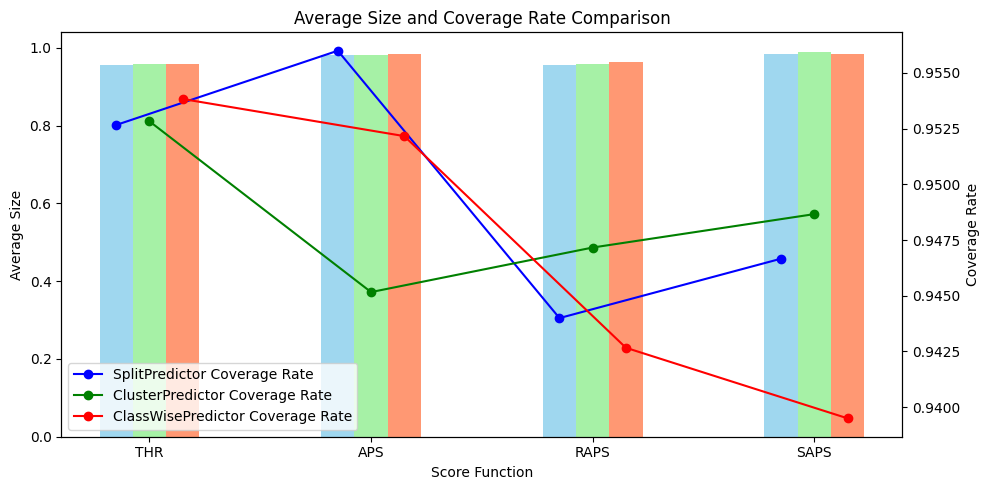

In [109]:
# Plotting
fig, ax1 = plt.subplots(figsize=(10, 5))
bar_width = 0.15
opacity = 0.8

# Define colors for bar charts
bar_colors = {'SplitPredictor': 'skyblue', 'ClusterPredictor': 'lightgreen', 'ClassWisePredictor': 'coral'}

# Plot bar charts for Average Size
for i, predictor in enumerate(predictors):
    subset = CNN_results[CNN_results["Predictor"] == predictor]
    ax1.bar(
        [val + i * bar_width for val in range(len(scores))],
        subset["Average Size"],
        bar_width,
        alpha=opacity,
        label=f'{predictor} Average Size',
        color=bar_colors[predictor]
    )

ax1.set_xlabel('Score Function')
ax1.set_ylabel('Average Size')
ax1.set_title('Average Size and Coverage Rate Comparison')
ax1.set_xticks([val + (len(predictors) - 1) * 0.5 * bar_width for val in range(len(scores))])
ax1.set_xticklabels(score_functions)
ax1.legend()
# Create a second y-axis for Coverage Rate
ax2 = ax1.twinx()
lines = []
# Define colors for line charts
line_colors = {'SplitPredictor': 'blue', 'ClusterPredictor': 'green', 'ClassWisePredictor': 'red'}

# Plot line charts for Coverage Rate
for i, predictor in enumerate(predictors):
    subset = CNN_results[CNN_results["Predictor"] == predictor]
    line = ax2.plot(
        [val + i * bar_width for val in range(len(scores))],
        subset["Coverage Rate"],
        marker='o',
        linestyle='-',
        label=f'{predictor} Coverage Rate',
        color=line_colors[predictor]
    )[0]
    lines.append(line)

ax2.set_ylabel('Coverage Rate', color='black')
ax2.tick_params('y', colors='black')

# Combine legends and move to the upper left
ax1.legend(lines, [line.get_label() for line in lines], loc='lower left', bbox_to_anchor=(0, 0))

plt.tight_layout()
plt.show()

#### Comparison of predictors and weights on SAPS

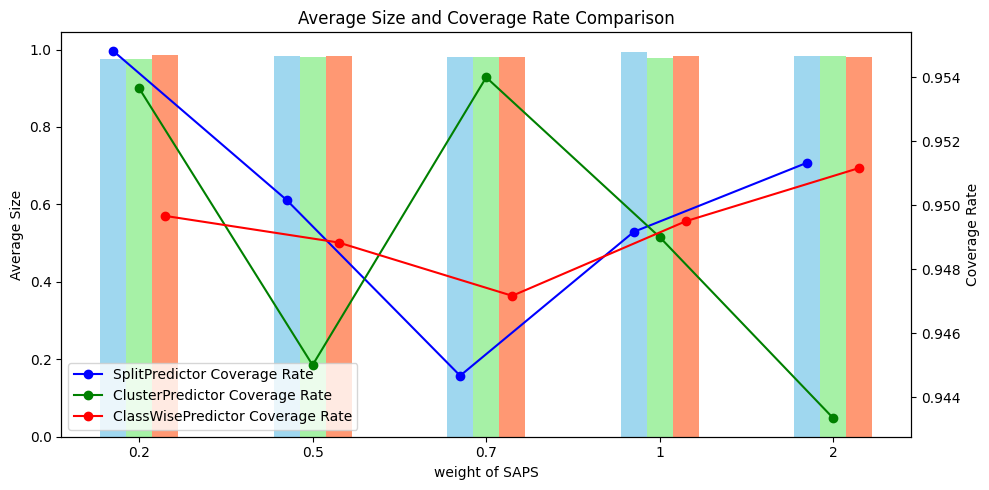

In [110]:
fig, ax1 = plt.subplots(figsize=(10, 5))
bar_width = 0.15
opacity = 0.8

# Define colors for bar charts
bar_colors = {'SplitPredictor': 'skyblue', 'ClusterPredictor': 'lightgreen', 'ClassWisePredictor': 'coral'}

for i, predictor in enumerate(predictors):
    subset = CNN_SAPS_weight[CNN_SAPS_weight["Predictor"] == predictor]
    ax1.bar(
        [val + i * bar_width for val in range(len(weight_selections))],
        subset["Average Size"],
        bar_width,
        alpha=opacity,
        label=f'{predictor} Average Size',
        color=bar_colors[predictor]
    )

ax1.set_xlabel('weight of SAPS')
ax1.set_ylabel('Average Size')
ax1.set_title('Average Size and Coverage Rate Comparison')
ax1.set_xticks([val + (len(predictors) - 1) * 0.5 * bar_width for val in range(len(weight_selections))])
ax1.set_xticklabels(weight_selections)
ax1.legend()
# Create a second y-axis for Coverage Rate
ax2 = ax1.twinx()
lines = []
# Define colors for line charts
line_colors = {'SplitPredictor': 'blue', 'ClusterPredictor': 'green', 'ClassWisePredictor': 'red'}

# Plot line charts for Coverage Rate
for i, predictor in enumerate(predictors):
    subset = CNN_SAPS_weight[CNN_SAPS_weight["Predictor"] == predictor]
    line = ax2.plot(
        [val + i * bar_width for val in range(len(weight_selections))],
        subset["Coverage Rate"],
        marker='o',
        linestyle='-',
        label=f'{predictor} Coverage Rate',
        color=line_colors[predictor]
    )[0]
    lines.append(line)

ax2.set_ylabel('Coverage Rate', color='black')
ax2.tick_params('y', colors='black')

# Combine legends and move to the upper left
ax1.legend(lines, [line.get_label() for line in lines], loc='lower left', bbox_to_anchor=(0, 0))

plt.tight_layout()
plt.show()

#### Comparison of different models(SplitPredictor,alpha=0.05,weight=0.2)

In [104]:
CNN_results1 = CNN_results[CNN_results['Predictor'] == "SplitPredictor"].copy().drop(columns=['Predictor'])
CNN_results1['Source'] = 'CNN'
LeNet5_results['Source'] = 'LeNet5'
ResNet18_results['Source'] = 'ResNet18'
result_concatenated = pd.concat([CNN_results1, LeNet5_results, ResNet18_results])
result_concatenated.reset_index(drop=True, inplace=True)
result_concatenated

,Score Function,Coverage Rate,Average Size,Source
0,THR,0.952667,0.956167,CNN
1,APS,0.956000,0.981167,CNN
2,RAPS,0.944000,0.956833,CNN
3,SAPS,0.946667,0.984333,CNN
4,THR,0.948833,0.952167,LeNet5
5,APS,0.949333,1.019500,LeNet5
6,RAPS,0.948333,0.971333,LeNet5
7,SAPS,0.944667,1.014000,LeNet5
8,THR,0.942500,0.947000,ResNet18
9,APS,0.945333,0.990167,ResNet18


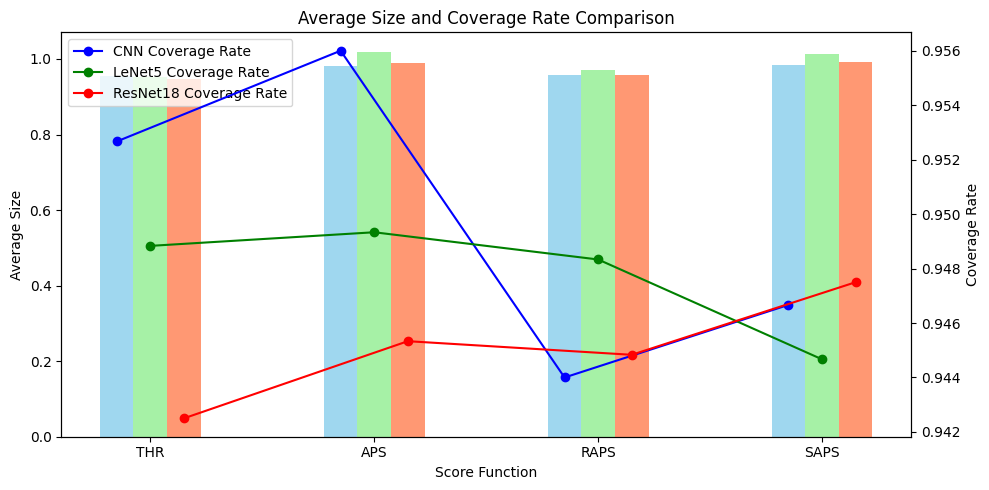

In [111]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# 定义颜色
colors = {'CNN': 'skyblue', 'LeNet5': 'lightgreen', 'ResNet18': 'coral'}

# 绘制条形图（Average Size）
bar_width = 0.15
opacity = 0.8
for i, source in enumerate(result_concatenated['Source'].unique()):
    subset = result_concatenated[result_concatenated['Source'] == source]
    ax1.bar(
        [val + i * bar_width for val in range(len(subset['Score Function']))],
        subset['Average Size'],
        bar_width,
        alpha=opacity,
        label=f'{source} Average Size',
        color=colors[source]
    )

ax1.set_xlabel('Score Function')
ax1.set_ylabel('Average Size')
ax1.set_title('Average Size and Coverage Rate Comparison')
ax1.set_xticks([val + (len(result_concatenated['Source'].unique()) - 1) * 0.5 * bar_width for val in range(len(result_concatenated['Score Function']))])
ax1.set_xticklabels(result_concatenated['Score Function'])
ax1.legend(loc='upper left')

# 创建第二个y轴
ax2 = ax1.twinx()
lines = []
line_colors = {'CNN': 'blue', 'LeNet5': 'green', 'ResNet18': 'red'}
for i, source in enumerate(result_concatenated['Source'].unique()):
    subset = result_concatenated[result_concatenated['Source'] == source]
    line = ax2.plot(
        [val + i * bar_width for val in range(len(subset['Score Function']))],
        subset['Coverage Rate'],
        marker='o',
        linestyle='-',
        label=f'{source} Coverage Rate',
        color=line_colors[source]
    )[0]
    lines.append(line)

ax2.set_ylabel('Coverage Rate', color='black')
ax2.tick_params('y', color='black')

# 合并图例，并左移1cm
ax1.legend(lines, [line.get_label() for line in lines], loc='upper left', bbox_to_anchor=(0, 1.0))

plt.tight_layout()
plt.show()